# NBA Game Prediction - LASSO Logistic Regression with Feature Selection

This notebook compares logistic regression models with LASSO regularization across different rolling window sizes (L3, L5, L10).

**Objectives:**
1. Load datasets with different rolling window sizes
2. Create meaningful interaction terms
3. Apply LASSO logistic regression for feature selection
4. Compare model effectiveness across window sizes

**Data Split:**
- Training: Seasons 2022, 2023, 2024
- Testing: Season 2025

**Target:** `win_away` (1 = away team wins, 0 = home team wins)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, log_loss, brier_score_loss, roc_curve
)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print("Packages loaded successfully!")


Packages loaded successfully!


## 1. Load Datasets


In [4]:
# Load all three datasets
df_L3 = pd.read_csv('nba_matchups_with_features_L3.csv')
df_L5 = pd.read_csv('nba_matchups_with_features_L5.csv')
df_L10 = pd.read_csv('nba_matchups_with_features_L10.csv')  # L10 is the default

# Convert date columns
df_L3['date'] = pd.to_datetime(df_L3['date'])
df_L5['date'] = pd.to_datetime(df_L5['date'])
df_L10['date'] = pd.to_datetime(df_L10['date'])

print("Dataset sizes:")
print(f"  L3:  {len(df_L3):,} matchups")
print(f"  L5:  {len(df_L5):,} matchups")
print(f"  L10: {len(df_L10):,} matchups")

# Check seasons available
print(f"\nSeasons in L3:  {sorted(df_L3['season'].unique())}")
print(f"Seasons in L5:  {sorted(df_L5['season'].unique())}")
print(f"Seasons in L10: {sorted(df_L10['season'].unique())}")


Dataset sizes:
  L3:  5,145 matchups
  L5:  5,145 matchups
  L10: 5,145 matchups

Seasons in L3:  [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Seasons in L5:  [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Seasons in L10: [np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [5]:
# Check season distribution
print("Games per season:")
print("\nL3:")
print(df_L3['season'].value_counts().sort_index())
print("\nL5:")
print(df_L5['season'].value_counts().sort_index())
print("\nL10:")
print(df_L10['season'].value_counts().sort_index())


Games per season:

L3:
season
2022    1290
2023    1288
2024    1285
2025    1282
Name: count, dtype: int64

L5:
season
2022    1290
2023    1288
2024    1285
2025    1282
Name: count, dtype: int64

L10:
season
2022    1290
2023    1288
2024    1285
2025    1282
Name: count, dtype: int64


## 2. Define Features and Create Train/Test Splits

**Split Strategy:**
- Training: Seasons 2022, 2023, 2024 (≤ 2024)
- Testing: Season 2025


In [6]:
def get_features_for_window(window_size):
    """
    Return list of base features for a given window size.
    Features are differential (away - home) unless noted.
    """
    w = f'L{window_size}'
    
    features = [
        # Advanced Efficiency Gaps
        f'off_rtg_{w}_diff',       # Offensive efficiency gap
        f'def_rtg_{w}_diff',       # Defensive efficiency gap
        f'net_rtg_{w}_diff',       # Net rating gap
        
        # Shooting Efficiency Gaps
        f'efg_pct_{w}_diff',       # Effective FG% gap
        f'3p_pct_{w}_diff',        # 3-point shooting gap
        f'3pa_rate_{w}_diff',      # 3-point volume gap
        
        # Form/Momentum
        f'win_pct_{w}_diff',       # Recent win percentage gap
        
        # Ball Control
        f'to_pct_{w}_diff',        # Turnover rate gap
        f'ft_rate_{w}_diff',       # Free throw rate gap
        
        # Rebounding & Playmaking
        f'oreb_pct_{w}_diff',      # Offensive rebounding gap
        f'ast_ratio_{w}_diff',     # Assist ratio gap
        
        # Defensive Stats
        f'stl_pct_{w}_diff',       # Steal percentage gap
        f'blk_pct_{w}_diff',       # Block percentage gap
        
        # Consistency & Momentum (non-window features)
        f'pts_std_{w}_diff',       # Scoring consistency gap
        'win_streak_diff',         # Win streak differential
        
        # Rest/Fatigue
        'rest_advantage',          # Rest days advantage
        'is_b2b_home',             # Home team back-to-back
        'is_b2b_away'              # Away team back-to-back
    ]
    
    return features

# Define features for each window size
features_L3 = get_features_for_window(3)
features_L5 = get_features_for_window(5)
features_L10 = get_features_for_window(10)

print(f"Base features per window: {len(features_L3)}")
print("\nFeatures:")
for i, f in enumerate(features_L3, 1):
    print(f"  {i:2d}. {f}")


Base features per window: 18

Features:
   1. off_rtg_L3_diff
   2. def_rtg_L3_diff
   3. net_rtg_L3_diff
   4. efg_pct_L3_diff
   5. 3p_pct_L3_diff
   6. 3pa_rate_L3_diff
   7. win_pct_L3_diff
   8. to_pct_L3_diff
   9. ft_rate_L3_diff
  10. oreb_pct_L3_diff
  11. ast_ratio_L3_diff
  12. stl_pct_L3_diff
  13. blk_pct_L3_diff
  14. pts_std_L3_diff
  15. win_streak_diff
  16. rest_advantage
  17. is_b2b_home
  18. is_b2b_away


In [7]:
def create_train_test_split(df, features, target='win_away'):
    """
    Split data into train (≤2024) and test (2025) sets.
    Returns X_train, X_test, y_train, y_test
    """
    # Verify all features exist
    missing = [f for f in features if f not in df.columns]
    if missing:
        print(f"Warning: Missing features: {missing}")
        features = [f for f in features if f in df.columns]
    
    # Drop any rows with missing values in features or target
    df_clean = df.dropna(subset=features + [target])
    
    # Split by season
    train_mask = df_clean['season'] <= 2024
    test_mask = df_clean['season'] == 2025
    
    X_train = df_clean.loc[train_mask, features].copy()
    X_test = df_clean.loc[test_mask, features].copy()
    y_train = df_clean.loc[train_mask, target].copy()
    y_test = df_clean.loc[test_mask, target].copy()
    
    print(f"Train: {len(X_train):,} games (seasons ≤ 2024)")
    print(f"Test:  {len(X_test):,} games (season 2025)")
    print(f"Train away win rate: {y_train.mean():.1%}")
    print(f"Test away win rate:  {y_test.mean():.1%}")
    
    return X_train, X_test, y_train, y_test, features

# Create splits for each window size
print("=" * 60)
print("L3 Dataset Split:")
print("=" * 60)
X_train_L3, X_test_L3, y_train_L3, y_test_L3, feat_L3 = create_train_test_split(df_L3, features_L3)

print("\n" + "=" * 60)
print("L5 Dataset Split:")
print("=" * 60)
X_train_L5, X_test_L5, y_train_L5, y_test_L5, feat_L5 = create_train_test_split(df_L5, features_L5)

print("\n" + "=" * 60)
print("L10 Dataset Split:")
print("=" * 60)
X_train_L10, X_test_L10, y_train_L10, y_test_L10, feat_L10 = create_train_test_split(df_L10, features_L10)


L3 Dataset Split:
Train: 3,863 games (seasons ≤ 2024)
Test:  1,282 games (season 2025)
Train away win rate: 44.1%
Test away win rate:  45.2%

L5 Dataset Split:
Train: 3,863 games (seasons ≤ 2024)
Test:  1,282 games (season 2025)
Train away win rate: 44.1%
Test away win rate:  45.2%

L10 Dataset Split:
Train: 3,863 games (seasons ≤ 2024)
Test:  1,282 games (season 2025)
Train away win rate: 44.1%
Test away win rate:  45.2%


## 3. Create Interaction Terms


In [8]:
def add_interaction_terms(X, window_size):
    """
    Add meaningful interaction terms to the feature matrix.
    Returns new X with interaction features and updated feature names.
    """
    X_new = X.copy()
    w = f'L{window_size}'
    
    # 1. Offense-Defense Synergy: Good offense + good defense = dominant team
    X_new['off_def_synergy'] = X_new[f'off_rtg_{w}_diff'] * (-X_new[f'def_rtg_{w}_diff'])
    
    # 2. Rest x Home B2B: Rest advantage matters more when opponent is tired
    X_new['rest_x_home_b2b'] = X_new['rest_advantage'] * X_new['is_b2b_home']
    
    # 3. Rest x Away B2B: Tired away team loses the benefit of rest
    X_new['rest_x_away_b2b'] = X_new['rest_advantage'] * X_new['is_b2b_away']
    
    # 4. Shooting Efficiency x Volume: Hot 3-point shooting with high volume
    X_new['3p_efficiency_x_volume'] = X_new[f'3p_pct_{w}_diff'] * X_new[f'3pa_rate_{w}_diff']
    
    # 5. eFG x Assist Ratio: Ball movement leads to better shots
    X_new['efg_x_ast'] = X_new[f'efg_pct_{w}_diff'] * X_new[f'ast_ratio_{w}_diff']
    
    # 6. Momentum x Win Streak: Hot teams with streak momentum
    X_new['form_x_streak'] = X_new[f'win_pct_{w}_diff'] * X_new['win_streak_diff']
    
    # 7. Win Pct x Net Rating: Good teams (by record) that also have good efficiency
    X_new['form_x_net_rtg'] = X_new[f'win_pct_{w}_diff'] * X_new[f'net_rtg_{w}_diff']
    
    # 8. Steal % x Turnover %: Disruptive defense against careless offense
    X_new['defense_disruption'] = X_new[f'stl_pct_{w}_diff'] * (-X_new[f'to_pct_{w}_diff'])
    
    # 9. OREB x eFG: Second chance opportunities with good shooting
    X_new['oreb_x_efg'] = X_new[f'oreb_pct_{w}_diff'] * X_new[f'efg_pct_{w}_diff']
    
    # 10. Block % x Def Rating: Rim protection contributing to overall defense
    X_new['rim_protection_x_def'] = X_new[f'blk_pct_{w}_diff'] * (-X_new[f'def_rtg_{w}_diff'])
    
    # 11. Consistency x Net Rating: Consistent good teams
    X_new['consistency_x_quality'] = (-X_new[f'pts_std_{w}_diff']) * X_new[f'net_rtg_{w}_diff']
    
    # 12. FT Rate x Net Rating: Teams that get to the line and are high quality
    X_new['ft_rate_x_quality'] = X_new[f'ft_rate_{w}_diff'] * X_new[f'net_rtg_{w}_diff']
    
    # 13. Off Rating x TO%: Efficient teams that also protect the ball
    X_new['off_efficiency_x_to'] = X_new[f'off_rtg_{w}_diff'] * (-X_new[f'to_pct_{w}_diff'])
    
    # 14. Double fatigue: Both teams on B2B (neutralizes advantage)
    X_new['double_b2b'] = X_new['is_b2b_home'] * X_new['is_b2b_away']
    
    return X_new

# Add interactions to all datasets
print("Adding interaction terms...")

X_train_L3_int = add_interaction_terms(X_train_L3, 3)
X_test_L3_int = add_interaction_terms(X_test_L3, 3)

X_train_L5_int = add_interaction_terms(X_train_L5, 5)
X_test_L5_int = add_interaction_terms(X_test_L5, 5)

X_train_L10_int = add_interaction_terms(X_train_L10, 10)
X_test_L10_int = add_interaction_terms(X_test_L10, 10)

print(f"\nFeatures after adding interactions:")
print(f"  Base features: {len(feat_L3)}")
print(f"  Total features (with interactions): {X_train_L3_int.shape[1]}")
print(f"\nNew interaction terms:")
interaction_cols = [c for c in X_train_L3_int.columns if c not in feat_L3]
for i, col in enumerate(interaction_cols, 1):
    print(f"  {i:2d}. {col}")


Adding interaction terms...

Features after adding interactions:
  Base features: 18
  Total features (with interactions): 32

New interaction terms:
   1. off_def_synergy
   2. rest_x_home_b2b
   3. rest_x_away_b2b
   4. 3p_efficiency_x_volume
   5. efg_x_ast
   6. form_x_streak
   7. form_x_net_rtg
   8. defense_disruption
   9. oreb_x_efg
  10. rim_protection_x_def
  11. consistency_x_quality
  12. ft_rate_x_quality
  13. off_efficiency_x_to
  14. double_b2b


## 4. Standardize Features


In [9]:
def standardize_features(X_train, X_test):
    """
    Standardize features using training data statistics.
    Returns scaled X_train, X_test, and the scaler.
    """
    scaler = StandardScaler()
    
    # Fit on training data only
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    
    # Transform test data using training statistics
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    return X_train_scaled, X_test_scaled, scaler

# Standardize each dataset
print("Standardizing features...")

X_train_L3_scaled, X_test_L3_scaled, scaler_L3 = standardize_features(X_train_L3_int, X_test_L3_int)
X_train_L5_scaled, X_test_L5_scaled, scaler_L5 = standardize_features(X_train_L5_int, X_test_L5_int)
X_train_L10_scaled, X_test_L10_scaled, scaler_L10 = standardize_features(X_train_L10_int, X_test_L10_int)

print("Done! Features standardized (mean=0, std=1)")


Standardizing features...
Done! Features standardized (mean=0, std=1)


## 5. Train LASSO Logistic Regression Models


In [10]:
def train_lasso_model(X_train, y_train, cv=5, max_iter=5000):
    """
    Train a LASSO logistic regression model with cross-validation.
    Returns the fitted model.
    """
    model = LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        cv=cv,
        Cs=20,
        scoring='roc_auc',
        max_iter=max_iter,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    return model

print("Training LASSO models (this may take a moment)...\n")

# Train L3 model
print("Training L3 model...")
model_L3 = train_lasso_model(X_train_L3_scaled, y_train_L3)
print(f"  Best C (1/lambda): {model_L3.C_[0]:.4f}")
print(f"  Non-zero coefficients: {np.sum(model_L3.coef_ != 0)}/{len(model_L3.coef_[0])}")

# Train L5 model
print("\nTraining L5 model...")
model_L5 = train_lasso_model(X_train_L5_scaled, y_train_L5)
print(f"  Best C (1/lambda): {model_L5.C_[0]:.4f}")
print(f"  Non-zero coefficients: {np.sum(model_L5.coef_ != 0)}/{len(model_L5.coef_[0])}")

# Train L10 model
print("\nTraining L10 model...")
model_L10 = train_lasso_model(X_train_L10_scaled, y_train_L10)
print(f"  Best C (1/lambda): {model_L10.C_[0]:.4f}")
print(f"  Non-zero coefficients: {np.sum(model_L10.coef_ != 0)}/{len(model_L10.coef_[0])}")

print("\nAll models trained!")


Training LASSO models (this may take a moment)...

Training L3 model...
  Best C (1/lambda): 0.0336
  Non-zero coefficients: 13/32

Training L5 model...
  Best C (1/lambda): 0.0336
  Non-zero coefficients: 13/32

Training L5 model...
  Best C (1/lambda): 0.0127
  Non-zero coefficients: 6/32

Training L10 model...
  Best C (1/lambda): 0.0127
  Non-zero coefficients: 6/32

Training L10 model...
  Best C (1/lambda): 0.0127
  Non-zero coefficients: 8/32

All models trained!
  Best C (1/lambda): 0.0127
  Non-zero coefficients: 8/32

All models trained!


## 6. Evaluate Models


In [11]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    """Comprehensive model evaluation."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'name': name,
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_prob),
        'test_auc': roc_auc_score(y_test, y_test_prob),
        'train_log_loss': log_loss(y_train, y_train_prob),
        'test_log_loss': log_loss(y_test, y_test_prob),
        'train_brier': brier_score_loss(y_train, y_train_prob),
        'test_brier': brier_score_loss(y_test, y_test_prob),
        'n_features': np.sum(model.coef_ != 0),
        'total_features': len(model.coef_[0]),
        'best_C': model.C_[0]
    }
    return metrics, y_test_prob

print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

metrics_L3, probs_L3 = evaluate_model(model_L3, X_train_L3_scaled, X_test_L3_scaled, y_train_L3, y_test_L3, 'L3 (3-game)')
metrics_L5, probs_L5 = evaluate_model(model_L5, X_train_L5_scaled, X_test_L5_scaled, y_train_L5, y_test_L5, 'L5 (5-game)')
metrics_L10, probs_L10 = evaluate_model(model_L10, X_train_L10_scaled, X_test_L10_scaled, y_train_L10, y_test_L10, 'L10 (10-game)')

comparison_df = pd.DataFrame([metrics_L3, metrics_L5, metrics_L10])
comparison_df = comparison_df.set_index('name')
comparison_df


MODEL EVALUATION


,train_accuracy,test_accuracy,train_auc,test_auc,train_log_loss,test_log_loss,train_brier,test_brier,n_features,total_features,best_C
name,,,,,,,,,,,
L3 (3-game),0.604194,0.611544,0.623072,0.651022,0.661429,0.653940,0.234537,0.231031,13,32,0.033598
L5 (5-game),0.614548,0.627925,0.629172,0.673624,0.661041,0.646993,0.234305,0.227590,6,32,0.012743
L10 (10-game),0.619984,0.653666,0.652942,0.701042,0.651867,0.631808,0.229923,0.220561,8,32,0.012743


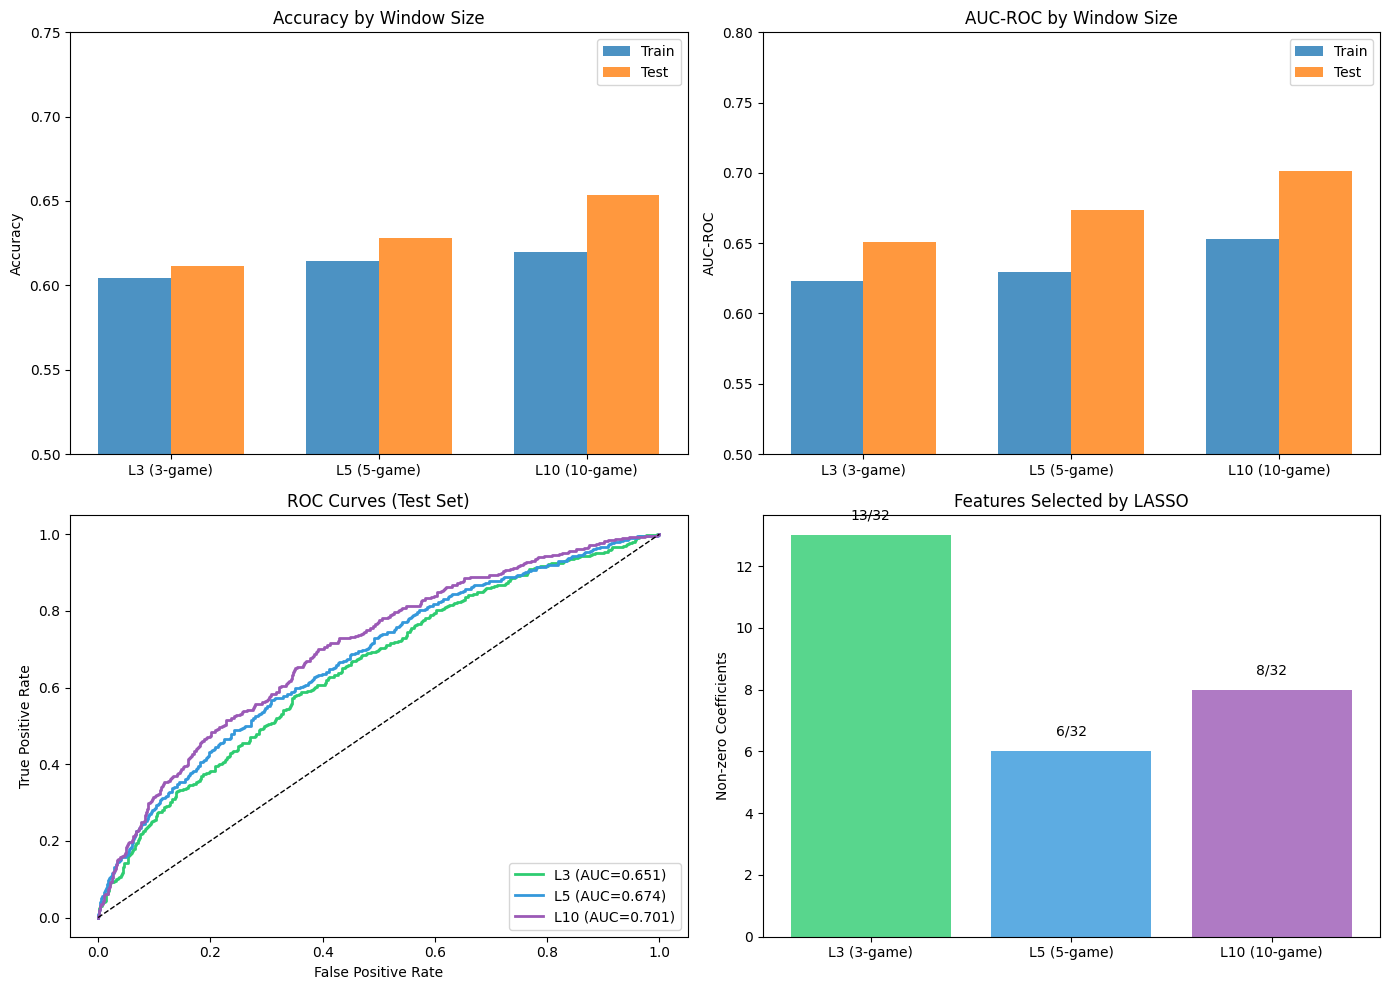


Figure saved as 'lasso_model_comparison.png'


In [12]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
windows = ['L3 (3-game)', 'L5 (5-game)', 'L10 (10-game)']
colors = ['#2ecc71', '#3498db', '#9b59b6']

# 1. Accuracy comparison
ax1 = axes[0, 0]
x = np.arange(3)
width = 0.35
train_acc = [metrics_L3['train_accuracy'], metrics_L5['train_accuracy'], metrics_L10['train_accuracy']]
test_acc = [metrics_L3['test_accuracy'], metrics_L5['test_accuracy'], metrics_L10['test_accuracy']]
ax1.bar(x - width/2, train_acc, width, label='Train', alpha=0.8)
ax1.bar(x + width/2, test_acc, width, label='Test', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(windows)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Window Size')
ax1.legend()
ax1.set_ylim([0.5, 0.75])

# 2. AUC comparison
ax2 = axes[0, 1]
train_auc = [metrics_L3['train_auc'], metrics_L5['train_auc'], metrics_L10['train_auc']]
test_auc = [metrics_L3['test_auc'], metrics_L5['test_auc'], metrics_L10['test_auc']]
ax2.bar(x - width/2, train_auc, width, label='Train', alpha=0.8)
ax2.bar(x + width/2, test_auc, width, label='Test', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(windows)
ax2.set_ylabel('AUC-ROC')
ax2.set_title('AUC-ROC by Window Size')
ax2.legend()
ax2.set_ylim([0.5, 0.8])

# 3. ROC Curves
ax3 = axes[1, 0]
for name, probs, y_test, color in [('L3', probs_L3, y_test_L3, colors[0]), ('L5', probs_L5, y_test_L5, colors[1]), ('L10', probs_L10, y_test_L10, colors[2])]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    ax3.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={auc:.3f})')
ax3.plot([0, 1], [0, 1], 'k--', lw=1)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves (Test Set)')
ax3.legend(loc='lower right')

# 4. Feature Selection
ax4 = axes[1, 1]
n_features = [metrics_L3['n_features'], metrics_L5['n_features'], metrics_L10['n_features']]
ax4.bar(x, n_features, color=colors, alpha=0.8)
for i, n in enumerate(n_features):
    ax4.text(i, n + 0.5, f'{n}/32', ha='center', fontsize=10)
ax4.set_xticks(x)
ax4.set_xticklabels(windows)
ax4.set_ylabel('Non-zero Coefficients')
ax4.set_title('Features Selected by LASSO')

plt.tight_layout()
plt.savefig('lasso_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved as 'lasso_model_comparison.png'")


## 7. Feature Importance Analysis


In [13]:
def get_feature_importance(model, feature_names, top_n=32):
    """Get feature importance from LASSO model coefficients."""
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_[0]
    })
    coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
    coef_df = coef_df.sort_values('abs_coefficient', ascending=False).reset_index(drop=True)
    coef_df['selected'] = coef_df['coefficient'] != 0
    return coef_df.head(top_n)

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

fi_L3 = get_feature_importance(model_L3, X_train_L3_scaled.columns, top_n=32)
fi_L5 = get_feature_importance(model_L5, X_train_L5_scaled.columns, top_n=32)
fi_L10 = get_feature_importance(model_L10, X_train_L10_scaled.columns, top_n=32)

print("\nL3 Model - Top Features:")
print(fi_L3[fi_L3['selected']][['feature', 'coefficient']].head(15).to_string())

print("\n" + "-" * 60)
print("\nL5 Model - Top Features:")
print(fi_L5[fi_L5['selected']][['feature', 'coefficient']].head(15).to_string())

print("\n" + "-" * 60)
print("\nL10 Model - Top Features:")
print(fi_L10[fi_L10['selected']][['feature', 'coefficient']].head(15).to_string())


FEATURE IMPORTANCE ANALYSIS

L3 Model - Top Features:
                  feature  coefficient
0         net_rtg_L3_diff     0.198662
1         win_streak_diff     0.141818
2         off_def_synergy     0.079611
3         rest_x_home_b2b     0.078851
4        3pa_rate_L3_diff     0.078682
5             is_b2b_away    -0.038714
6         off_rtg_L3_diff     0.038422
7          to_pct_L3_diff    -0.036781
8          rest_advantage     0.034408
9               efg_x_ast    -0.028669
10            is_b2b_home     0.028208
11  consistency_x_quality    -0.018809
12             oreb_x_efg    -0.004336

------------------------------------------------------------

L5 Model - Top Features:
            feature  coefficient
0   net_rtg_L5_diff     0.303281
1   rest_x_home_b2b     0.050501
2   off_rtg_L5_diff     0.041342
3   win_streak_diff     0.037774
4    rest_advantage     0.021297
5  3pa_rate_L5_diff     0.008256

------------------------------------------------------------

L10 Model - Top Fe

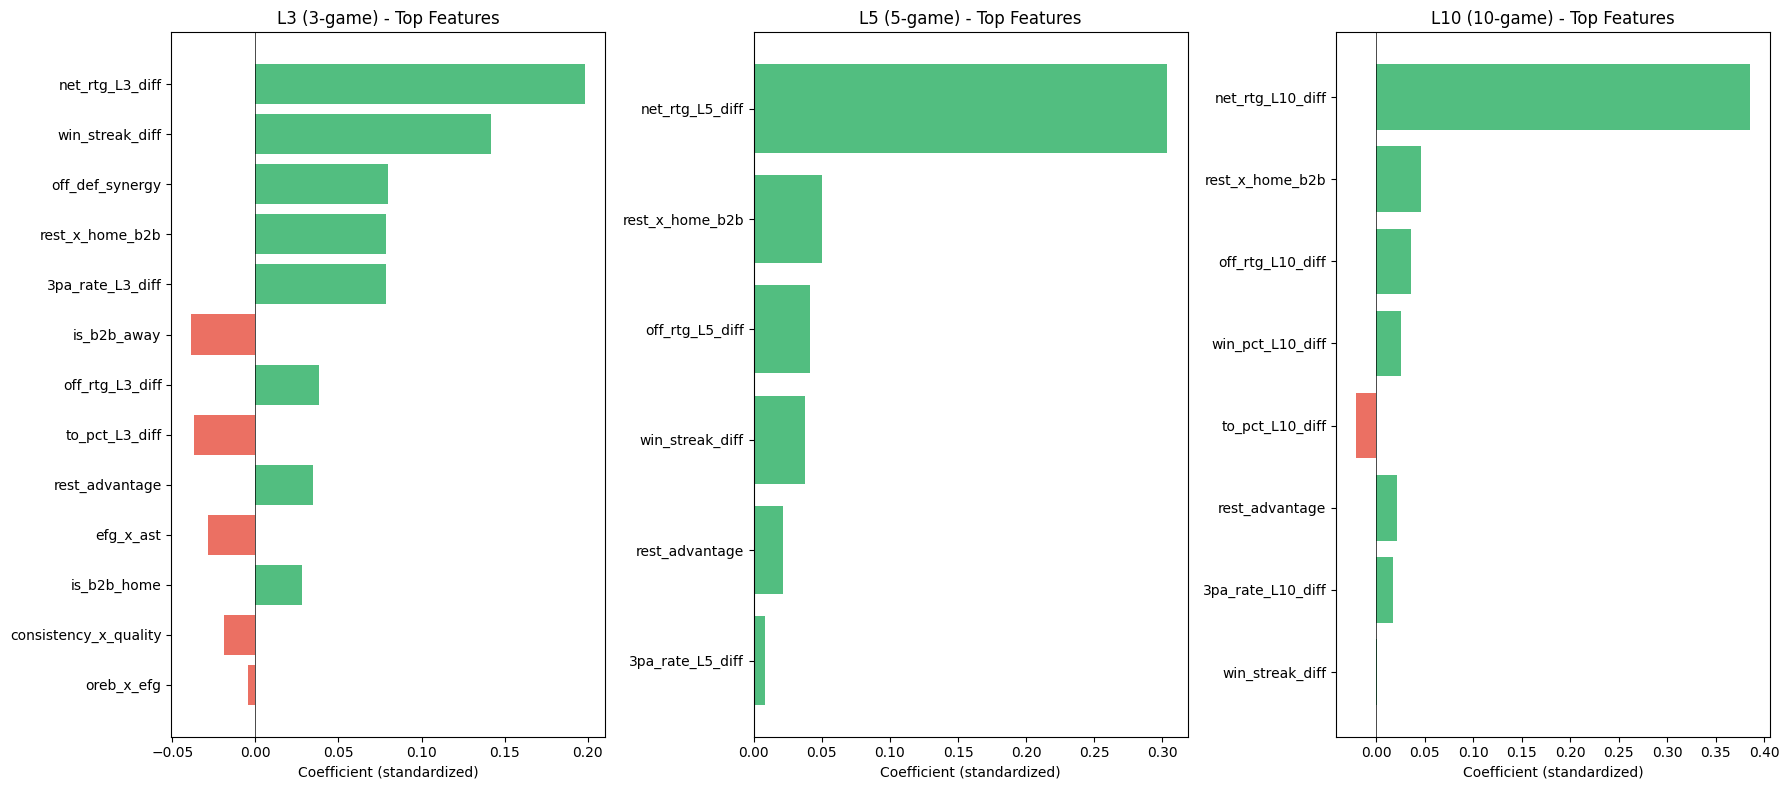


Figure saved as 'feature_importance_comparison.png'


In [14]:
# Visualize feature importance for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for ax, fi, name, color in zip(axes, [fi_L3, fi_L5, fi_L10], ['L3 (3-game)', 'L5 (5-game)', 'L10 (10-game)'], colors):
    fi_plot = fi[fi['selected']].head(15).copy()
    if len(fi_plot) > 0:
        colors_bar = ['#27ae60' if c > 0 else '#e74c3c' for c in fi_plot['coefficient']]
        y_pos = np.arange(len(fi_plot))
        ax.barh(y_pos, fi_plot['coefficient'], color=colors_bar, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(fi_plot['feature'])
        ax.set_xlabel('Coefficient (standardized)')
        ax.set_title(f'{name} - Top Features')
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved as 'feature_importance_comparison.png'")


## 8. Cross-Model Feature Comparison


In [15]:
# Compare which features are selected across models
def get_selected_features(model, feature_names):
    mask = model.coef_[0] != 0
    return set(np.array(feature_names)[mask])

selected_L3 = get_selected_features(model_L3, X_train_L3_scaled.columns)
selected_L5 = get_selected_features(model_L5, X_train_L5_scaled.columns)
selected_L10 = get_selected_features(model_L10, X_train_L10_scaled.columns)

def normalize_feature_name(name):
    for w in ['_L3', '_L5', '_L10']:
        name = name.replace(w, '_LX')
    return name

selected_L3_norm = {normalize_feature_name(f) for f in selected_L3}
selected_L5_norm = {normalize_feature_name(f) for f in selected_L5}
selected_L10_norm = {normalize_feature_name(f) for f in selected_L10}

all_selected = selected_L3_norm & selected_L5_norm & selected_L10_norm

print("=" * 60)
print("FEATURE SELECTION COMPARISON")
print("=" * 60)

print(f"\nFeatures selected in ALL models ({len(all_selected)}):")
for f in sorted(all_selected):
    print(f"  - {f}")

print(f"\nFeatures selected in at least 2 models:")
at_least_two = (selected_L3_norm & selected_L5_norm) | (selected_L5_norm & selected_L10_norm) | (selected_L3_norm & selected_L10_norm)
for f in sorted(at_least_two - all_selected):
    in_models = []
    if f in selected_L3_norm: in_models.append('L3')
    if f in selected_L5_norm: in_models.append('L5')
    if f in selected_L10_norm: in_models.append('L10')
    print(f"  - {f} ({', '.join(in_models)})")

print(f"\nTotal unique features selected:")
print(f"  L3:  {len(selected_L3)}")
print(f"  L5:  {len(selected_L5)}")
print(f"  L10: {len(selected_L10)}")


FEATURE SELECTION COMPARISON

Features selected in ALL models (6):
  - 3pa_rate_LX_diff
  - net_rtg_LX_diff
  - off_rtg_LX_diff
  - rest_advantage
  - rest_x_home_b2b
  - win_streak_diff

Features selected in at least 2 models:
  - to_pct_LX_diff (L3, L10)

Total unique features selected:
  L3:  13
  L5:  6
  L10: 8


## 9. Summary and Recommendations


In [16]:
# Final summary
print("=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\n" + "-" * 40)
print("MODEL PERFORMANCE ON TEST SET (2025 Season)")
print("-" * 40)
print(f"\n{'Window':<15} {'Accuracy':<12} {'AUC-ROC':<12} {'Log Loss':<12} {'Brier':<12} {'Features'}")
print("=" * 75)
for m in [metrics_L3, metrics_L5, metrics_L10]:
    print(f"{m['name']:<15} {m['test_accuracy']:.4f}       {m['test_auc']:.4f}       {m['test_log_loss']:.4f}       {m['test_brier']:.4f}       {m['n_features']}/{m['total_features']}")

best_by_accuracy = max([metrics_L3, metrics_L5, metrics_L10], key=lambda x: x['test_accuracy'])
best_by_auc = max([metrics_L3, metrics_L5, metrics_L10], key=lambda x: x['test_auc'])
best_by_logloss = min([metrics_L3, metrics_L5, metrics_L10], key=lambda x: x['test_log_loss'])

print("\n" + "-" * 40)
print("BEST MODELS BY METRIC")
print("-" * 40)
print(f"Best by Accuracy:  {best_by_accuracy['name']} ({best_by_accuracy['test_accuracy']:.4f})")
print(f"Best by AUC-ROC:   {best_by_auc['name']} ({best_by_auc['test_auc']:.4f})")
print(f"Best by Log Loss:  {best_by_logloss['name']} ({best_by_logloss['test_log_loss']:.4f})")

print("\n" + "-" * 40)
print("KEY INSIGHTS")
print("-" * 40)

home_win_rate = 1 - y_test_L3.mean()
print(f"\n1. BASELINE: Always pick home team would get {home_win_rate:.1%} accuracy")
print(f"   Our best model: {best_by_accuracy['test_accuracy']:.1%} (improvement: +{(best_by_accuracy['test_accuracy'] - home_win_rate)*100:.1f}pp)")

print(f"\n2. WINDOW SIZE EFFECT:")
print(f"   - Shorter windows (L3) capture recent form but may be noisy")
print(f"   - Longer windows (L10) are more stable but may miss recent changes")

print(f"\n3. FEATURE SELECTION:")
print(f"   - LASSO selected {metrics_L3['n_features']}-{metrics_L10['n_features']} features from {metrics_L3['total_features']} candidates")


FINAL SUMMARY

----------------------------------------
MODEL PERFORMANCE ON TEST SET (2025 Season)
----------------------------------------

Window          Accuracy     AUC-ROC      Log Loss     Brier        Features
L3 (3-game)     0.6115       0.6510       0.6539       0.2310       13/32
L5 (5-game)     0.6279       0.6736       0.6470       0.2276       6/32
L10 (10-game)   0.6537       0.7010       0.6318       0.2206       8/32

----------------------------------------
BEST MODELS BY METRIC
----------------------------------------
Best by Accuracy:  L10 (10-game) (0.6537)
Best by AUC-ROC:   L10 (10-game) (0.7010)
Best by Log Loss:  L10 (10-game) (0.6318)

----------------------------------------
KEY INSIGHTS
----------------------------------------

1. BASELINE: Always pick home team would get 54.8% accuracy
   Our best model: 65.4% (improvement: +10.5pp)

2. WINDOW SIZE EFFECT:
   - Shorter windows (L3) capture recent form but may be noisy
   - Longer windows (L10) are more sta

In [17]:
# Create summary table
summary_table = pd.DataFrame({
    'Metric': ['Test Accuracy', 'Test AUC-ROC', 'Test Log Loss', 'Test Brier Score', 
               'Train Accuracy', 'Train AUC-ROC', 'Features Selected', 'Best C (1/lambda)'],
    'L3 (3-game)': [f"{metrics_L3['test_accuracy']:.4f}", f"{metrics_L3['test_auc']:.4f}", 
                   f"{metrics_L3['test_log_loss']:.4f}", f"{metrics_L3['test_brier']:.4f}",
                   f"{metrics_L3['train_accuracy']:.4f}", f"{metrics_L3['train_auc']:.4f}",
                   f"{metrics_L3['n_features']}/{metrics_L3['total_features']}", f"{metrics_L3['best_C']:.4f}"],
    'L5 (5-game)': [f"{metrics_L5['test_accuracy']:.4f}", f"{metrics_L5['test_auc']:.4f}",
                   f"{metrics_L5['test_log_loss']:.4f}", f"{metrics_L5['test_brier']:.4f}",
                   f"{metrics_L5['train_accuracy']:.4f}", f"{metrics_L5['train_auc']:.4f}",
                   f"{metrics_L5['n_features']}/{metrics_L5['total_features']}", f"{metrics_L5['best_C']:.4f}"],
    'L10 (10-game)': [f"{metrics_L10['test_accuracy']:.4f}", f"{metrics_L10['test_auc']:.4f}",
                     f"{metrics_L10['test_log_loss']:.4f}", f"{metrics_L10['test_brier']:.4f}",
                     f"{metrics_L10['train_accuracy']:.4f}", f"{metrics_L10['train_auc']:.4f}",
                     f"{metrics_L10['n_features']}/{metrics_L10['total_features']}", f"{metrics_L10['best_C']:.4f}"]
})
summary_table = summary_table.set_index('Metric')
print("\n" + "=" * 60)
print("COMPLETE COMPARISON TABLE")
print("=" * 60)
summary_table



COMPLETE COMPARISON TABLE


,L3 (3-game),L5 (5-game),L10 (10-game)
Metric,,,
Test Accuracy,0.6115,0.6279,0.6537
Test AUC-ROC,0.6510,0.6736,0.7010
Test Log Loss,0.6539,0.6470,0.6318
Test Brier Score,0.2310,0.2276,0.2206
Train Accuracy,0.6042,0.6145,0.6200
Train AUC-ROC,0.6231,0.6292,0.6529
Features Selected,13/32,6/32,8/32
Best C (1/lambda),0.0336,0.0127,0.0127



CONFUSION MATRIX - L10 MODEL (Best Model)


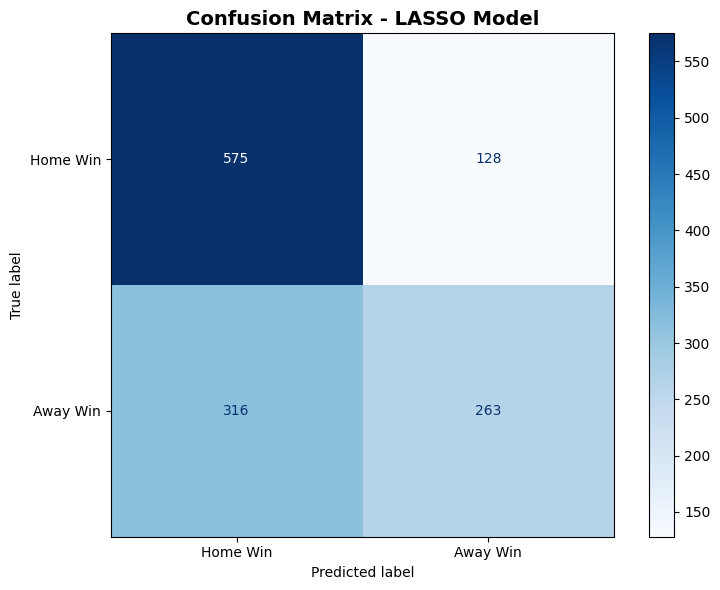


True Negatives:  575
False Positives: 128
False Negatives: 316
True Positives:  263


In [18]:
# Confusion Matrix - L10 Model
from sklearn.metrics import ConfusionMatrixDisplay

print("\n" + "=" * 60)
print("CONFUSION MATRIX - L10 MODEL (Best Model)")
print("=" * 60)

cm_L10 = confusion_matrix(y_test_L10, probs_L10 > 0.5)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_L10, display_labels=['Home Win', 'Away Win'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - LASSO Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives:  {cm_L10[0, 0]}")
print(f"False Positives: {cm_L10[0, 1]}")
print(f"False Negatives: {cm_L10[1, 0]}")
print(f"True Positives:  {cm_L10[1, 1]}")


ROC CURVE - L10 MODEL (Best Model)


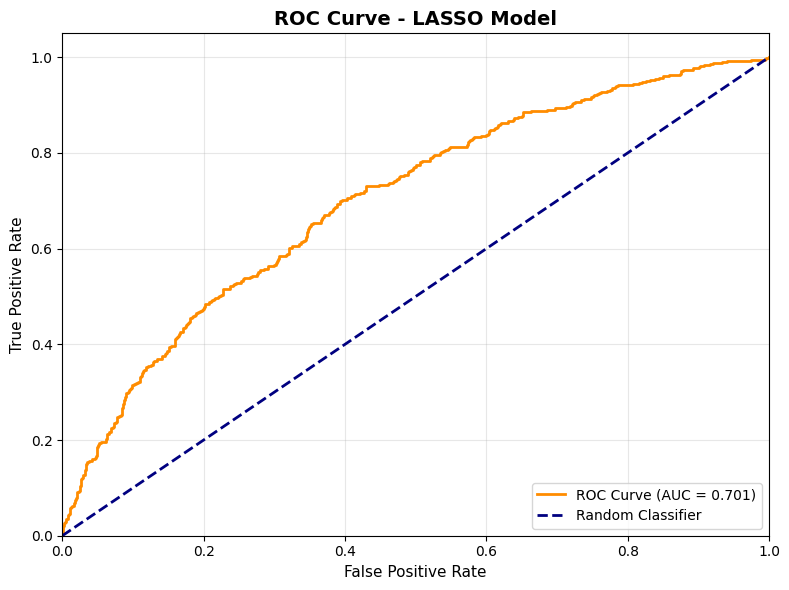


AUC-ROC Score: 0.7010


In [19]:
# ROC Curve - L10 Model
print("\n" + "=" * 60)
print("ROC CURVE - L10 MODEL (Best Model)")
print("=" * 60)

fpr_L10, tpr_L10, thresholds = roc_curve(y_test_L10, probs_L10)
roc_auc_L10 = roc_auc_score(y_test_L10, probs_L10)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_L10, tpr_L10, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_L10:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve - LASSO Model', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC-ROC Score: {roc_auc_L10:.4f}")


FEATURE IMPORTANCE - L10 MODEL (Best Model)

Top Features Selected by LASSO (L10 Model):
          feature  coefficient
 net_rtg_L10_diff     0.385295
  rest_x_home_b2b     0.046361
 off_rtg_L10_diff     0.036049
 win_pct_L10_diff     0.025331
  to_pct_L10_diff    -0.021313
   rest_advantage     0.021198
3pa_rate_L10_diff     0.017547
  win_streak_diff     0.000865


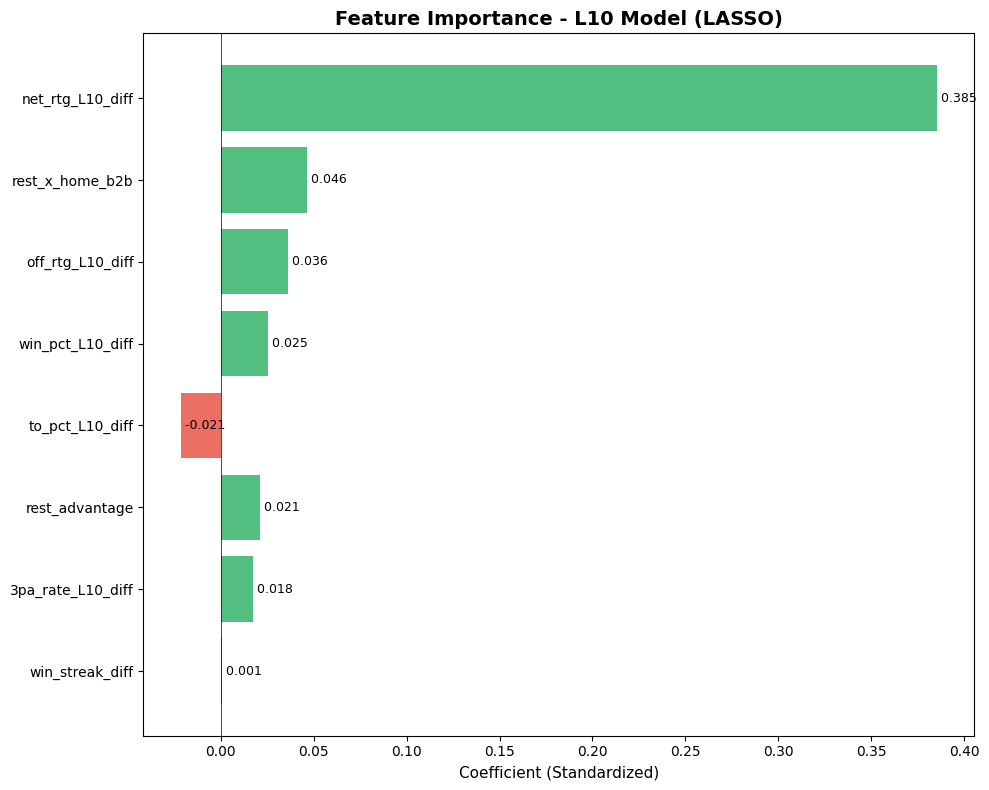


Total selected features (L10 Model): 8
Positive coefficients: 7
Negative coefficients: 1


In [20]:
# Feature Importance - L10 Model
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE - L10 MODEL (Best Model)")
print("=" * 60)

# Get selected features from L10 model
fi_L10_plot = fi_L10[fi_L10['selected']].head(20).copy()

print("\nTop Features Selected by LASSO (L10 Model):")
print(fi_L10_plot[['feature', 'coefficient']].to_string(index=False))

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

colors_bar = ['#27ae60' if c > 0 else '#e74c3c' for c in fi_L10_plot['coefficient']]
y_pos = np.arange(len(fi_L10_plot))
ax.barh(y_pos, fi_L10_plot['coefficient'], color=colors_bar, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(fi_L10_plot['feature'], fontsize=10)
ax.set_xlabel('Coefficient (Standardized)', fontsize=11)
ax.set_title('Feature Importance - L10 Model (LASSO)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.invert_yaxis()

# Add value labels on bars
for i, (idx, row) in enumerate(fi_L10_plot.iterrows()):
    ax.text(row['coefficient'], i, f" {row['coefficient']:.3f}", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTotal selected features (L10 Model): {len(fi_L10_plot)}")
print(f"Positive coefficients: {(fi_L10_plot['coefficient'] > 0).sum()}")
print(f"Negative coefficients: {(fi_L10_plot['coefficient'] < 0).sum()}")

## 10. Save Results


In [21]:
# Save coefficient tables
fi_L3.to_csv('lasso_coefficients_L3.csv', index=False)
fi_L5.to_csv('lasso_coefficients_L5.csv', index=False)
fi_L10.to_csv('lasso_coefficients_L10.csv', index=False)

# Save summary table
summary_table.to_csv('model_comparison_summary.csv')

print("Saved: lasso_coefficients_L3.csv")
print("Saved: lasso_coefficients_L5.csv")
print("Saved: lasso_coefficients_L10.csv")
print("Saved: model_comparison_summary.csv")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)


Saved: lasso_coefficients_L3.csv
Saved: lasso_coefficients_L5.csv
Saved: lasso_coefficients_L10.csv
Saved: model_comparison_summary.csv

ANALYSIS COMPLETE!
